In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import seaborn as sns
import cv2 as cv
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from glob import glob
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
df = pd.read_csv('/kaggle/input/skin-cancer-mnist-ham10000/HAM10000_metadata.csv')

In [3]:
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
df.isnull().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

In [5]:
df['age'].fillna(int(df['age'].mean()),inplace=True)

/tmp/ipykernel_23/2028790963.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['age'].fillna(int(df['age'].mean()),inplace=True)


In [6]:
lesion_type_dict = {
    'nv': 'Melanocytic nevi',
    'mel': 'Melanoma',
    'bkl': 'Benign keratosis-like lesions ',
    'bcc': 'Basal cell carcinoma',
    'akiec': 'Actinic keratoses',
    'vasc': 'Vascular lesions',
    'df': 'Dermatofibroma'
}

In [7]:
base_skin_dir = ('/kaggle/input/skin-cancer-mnist-ham10000')
imageid_path_dict = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join(base_skin_dir, '*', '*.jpg'))}

In [8]:
df['path'] = df['image_id'].map(imageid_path_dict.get)
df['cell_type'] = df['dx'].map(lesion_type_dict.get)

In [9]:
df['cell_type_idx'] = pd.Categorical(df['cell_type']).codes
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization,path,cell_type,cell_type_idx
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear,/kaggle/input/skin-cancer-mnist-ham10000/ham10...,Benign keratosis-like lesions,2


In [10]:
from keras.preprocessing.image import img_to_array, array_to_img
df['image'] = df['path'].map(lambda x : img_to_array(cv.resize(cv.imread(x),(224,224),
                                                               interpolation=cv.INTER_AREA)))

<Axes: xlabel='cell_type'>

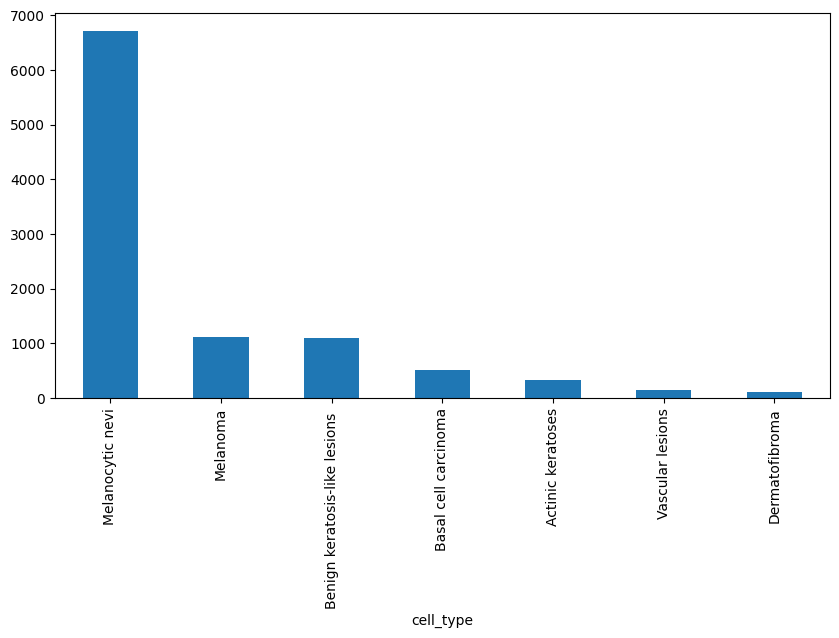

In [11]:
fig, ax1 = plt.subplots(1, 1, figsize = (10, 5))
df['cell_type'].value_counts().plot(kind='bar', ax=ax1)

In [12]:
df2 = df[["image", 'cell_type_idx']]

In [13]:
X=df2['image']
Y=df2['cell_type_idx']

In [14]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state = 0) 

In [15]:
x_train = np.asarray(x_train.tolist())
x_test = np.asarray(x_test.tolist())

In [16]:
y_train = to_categorical(y_train, num_classes = 7)
y_test = to_categorical(y_test, num_classes = 7)

In [17]:
x_train, x_validate, y_train, y_validate = train_test_split(x_train, y_train, test_size = 0.1, random_state = 2)

In [18]:
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.models import Model

base_model = DenseNet121(weights='/kaggle/input/densenetweights/tensorflow2/default/1/densenet121_weights_tf_dim_ordering_tf_kernels_notop.h5', include_top=False, input_shape=(224, 224, 3))
x = Flatten()(base_model.output)
x = Dense(256, activation='relu')(x)
x = Dense(7, activation='softmax')(x)  # Number of classes
model = Model(inputs=base_model.input, outputs=x)


In [19]:
train_datagen = ImageDataGenerator(
    horizontal_flip=True,
    preprocessing_function=tf.keras.applications.mobilenet.preprocess_input
)

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
x_train_gen = train_datagen.flow(x_train, y_train, batch_size=16)
val_data = train_datagen.flow(x_validate, y_validate, batch_size=16)

In [20]:
history = model.fit(
    x_train_gen,
    epochs=25,
    validation_data=val_data,
    batch_size=32  # Batch size should match the batch size in the data generator
)

Epoch 1/25


/opt/conda/lib/python3.10/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
I0000 00:00:1734512729.915524      88 service.cc:145] XLA service 0x7e4e8c025e50 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734512729.915601      88 service.cc:153]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1734512804.322769      88 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


451/451 ━━━━━━━━━━━━━━━━━━━━ 260s 302ms/step - accuracy: 0.6629 - loss: 1.8243 - val_accuracy: 0.7070 - val_loss: 0.7525
Epoch 2/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - accuracy: 0.7561 - loss: 0.6936 - val_accuracy: 0.6845 - val_loss: 1.1899
Epoch 3/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 51s 112ms/step - accuracy: 0.7729 - loss: 0.6340 - val_accuracy: 0.7257 - val_loss: 0.8263
Epoch 4/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - accuracy: 0.7720 - loss: 0.6744 - val_accuracy: 0.7132 - val_loss: 0.8472
Epoch 5/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - accuracy: 0.7405 - loss: 0.8033 - val_accuracy: 0.7444 - val_loss: 1.5212
Epoch 6/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - accuracy: 0.7511 - loss: 0.7297 - val_accuracy: 0.7494 - val_loss: 0.6802
Epoch 7/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 50s 112ms/step - accuracy: 0.7761 - loss: 0.6350 - val_accuracy: 0.7618 - val_loss: 0.6159
Epoch 8/25
451/451 ━━━━━━━━━━━━━━━━━━━━ 50s 111ms/step - accuracy: 0.7905 - loss: 0.5715 - va

In [26]:
model.save('/kaggle/working/DenseNetV2M.h5')
print("hello world")

hello world


In [27]:
import shutil

# Move the file to the Kaggle output directory
shutil.move('/kaggle/working/DenseNetV2M.h5', '/kaggle/output/DenseNetV2M.h5')


FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/output/DenseNetV2M.h5'

In [23]:
import os
print(os.listdir('/kaggle/working'))


['.virtual_documents', 'DenseNetV2M.h5']
